In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from keras.models import Sequential
from keras.layers import Dense, LSTM, TimeDistributed
from keras.optimizers import RMSprop

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

sns.set()
%matplotlib inline

Using TensorFlow backend.


In [3]:
with pd.HDFStore('/home/ronniee/Documents/kaggle/air-quality-madrid/madrid.h5') as data:
    df = data['28079016']
    
df = df.sort_index()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 151776 entries, 2001-01-01 01:00:00 to 2018-05-01 00:00:00
Data columns (total 7 columns):
CO      151182 non-null float64
NO      64045 non-null float64
NO_2    151290 non-null float64
NOx     92321 non-null float64
O_3     151131 non-null float64
PM10    75920 non-null float64
SO_2    78497 non-null float64
dtypes: float64(7)
memory usage: 9.3 MB


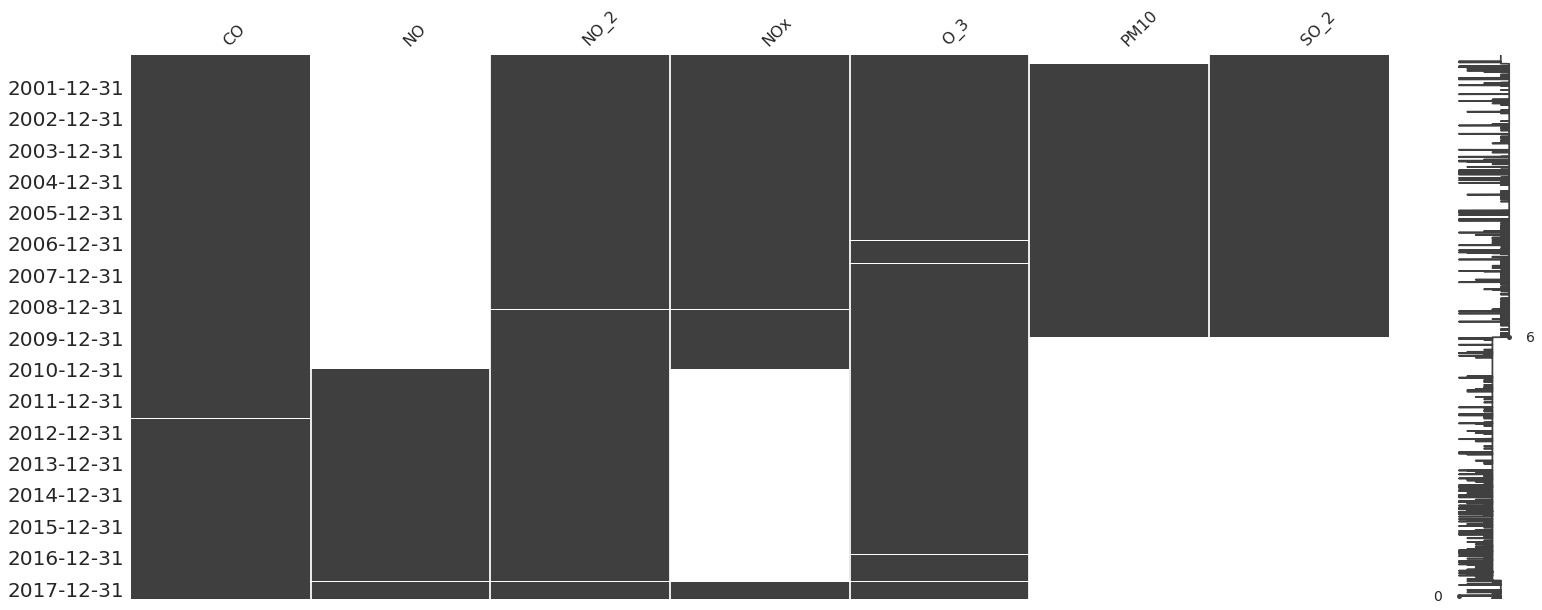

In [4]:
msno.matrix(df, freq='Y')

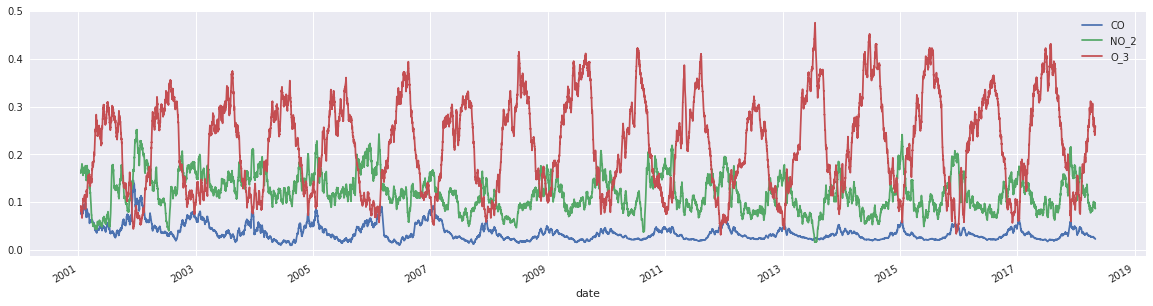

In [5]:
fig, ax = plt.subplots(figsize=(20, 5))

candidates = df[['CO', 'NO_2', 'O_3']] 

candidates /= candidates.max(axis=0)

(candidates.interpolate(method='time')
           .rolling(window=24*15).mean()
           .plot(ax=ax))

In [6]:
def pivot_with_offset(series, offset):
    pivot = pd.DataFrame(index=df.index)

    for t in range(offset * 2):
        pivot['t_{}'.format(t)] = series.shift(-t)

    pivot = pivot.dropna(how='any')
    return pivot


offset = 24

series = (df.NO_2.interpolate(method='time')
                 .pipe(pivot_with_offset, offset)
                 .apply(np.log, axis=1)
                 .replace(-np.inf))

# Get only timestamps at 00:00 and 12:00
series = series[(series.index.hour % 12) == 0]

# Make it a multiple of the chosen batch_size
if series.shape[0] % 32 != 0:
    series = series.iloc[:-(series.shape[0]%32)]

In [7]:
test_ratio = 0.2

split_point = int(series.shape[0] * (1 - test_ratio))
split_point -= split_point % 32

np_series = series.values

X_train = series.values[:split_point , :offset]
y_train = series.values[:split_point, offset:]
X_test = series.values[split_point:, :offset]
y_test = series.values[split_point:, offset:]

In [8]:
# Scale only to train data to prevent look-ahead bias
lift = X_train.min()
scale = X_train.max()

def scale_array(arr, lift, scale):
    return (arr - lift) / scale

X_train = np.expand_dims(scale_array(X_train, lift, scale), axis=2)
y_train = np.expand_dims(scale_array(y_train, lift, scale), axis=2)
X_test = np.expand_dims(scale_array(X_test, lift, scale), axis=2)
y_test = np.expand_dims(scale_array(y_test, lift, scale), axis=2)

In [9]:
def create_lstm(offset, neurons=(2,1), batch_size=32, lr=0.005, n_features=1):
    model = Sequential()
    
    # First LSTM layer
    model.add(LSTM(
        neurons[0], return_sequences=True, stateful=True, 
        batch_input_shape=(batch_size, offset, n_features))
    )
    
    
    # Second LSTM layer if defined
    if neurons[1]:
        model.add(LSTM(
            neurons[1], return_sequences=True, stateful=True, 
            batch_input_shape=(batch_size, offset, n_features))
        )
    
    # TimeDistributed layer to generate all the timesteps
    model.add(TimeDistributed(Dense(1)))
    
    optimizer = RMSprop(lr=lr)
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    
    return model

In [10]:
def train_model(model, X_train, y_train, batch_size=32, epochs=20):
    mse = list()

    for i in range(epochs):
        if i % 1 == 0:
            print('Epoch {:02d}/{}...'.format(i + 1, epochs), end=' ')

        log = model.fit(
            X_train, y_train, 
            epochs=1, batch_size=32, 
            verbose=0, shuffle=False
        )
    
        mse.append(log.history['loss'][-1])
        print('loss: {:.4f}'.format(mse[-1]))
    
        model.reset_states()
        
    return model, mse

In [11]:
def validate_model(model, X_test, y_test):
    preds = model.predict(X_test)
    model.reset_states()
    return np.mean((y_test - preds) ** 2)


In [12]:
model = create_lstm(offset)
model, _ = train_model(model, X_train, y_train)

model.fit(
    X_train, y_train, 
    epochs=1, batch_size=32, 
    verbose=1, shuffle=False
)
model.reset_states()

preds = model.predict(X_test)

Epoch 01/20... loss: 0.0158
Epoch 02/20... loss: 0.0127
Epoch 03/20... loss: 0.0118
Epoch 04/20... loss: 0.0115
Epoch 05/20... loss: 0.0112
Epoch 06/20... loss: 0.0110
Epoch 07/20... loss: 0.0109
Epoch 08/20... loss: 0.0109
Epoch 09/20... loss: 0.0108
Epoch 10/20... loss: 0.0108
Epoch 11/20... loss: 0.0108
Epoch 12/20... loss: 0.0108
Epoch 13/20... loss: 0.0107
Epoch 14/20... loss: 0.0107
Epoch 15/20... loss: 0.0107
Epoch 16/20... loss: 0.0107
Epoch 17/20... loss: 0.0107
Epoch 18/20... loss: 0.0107
Epoch 19/20... loss: 0.0107
Epoch 20/20... loss: 0.0107
Epoch 1/1
10112/10112 [==============================] - 47s 5ms/step - loss: 0.0107


In [13]:
'MSE: {:.5f}'.format(validate_model(model, X_test, y_test))

'MSE: 0.01286'

In [14]:
model.save('madrid_airquality.h5')

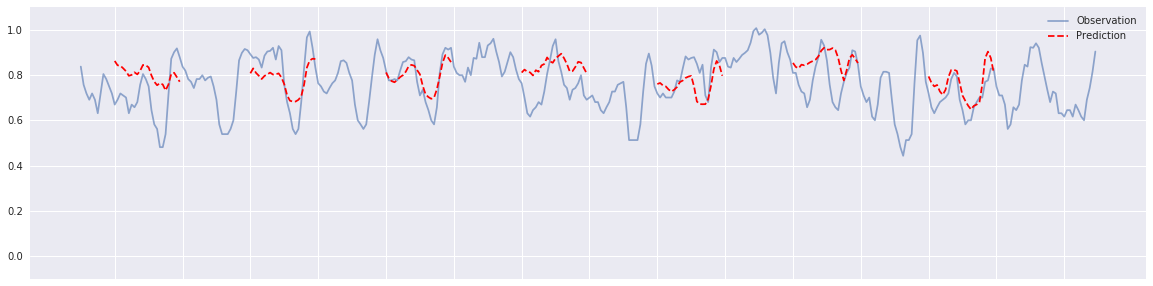

In [15]:
fig, ax = plt.subplots(figsize=(20, 5))

start = X_test.shape[0] - 42
interval = X_test[start+3:start+33:2, :, 0].reshape(-1, 1)

truth, = plt.plot(np.arange(24*15), interval, alpha=0.6)

old_preds = list()

for point in range(1, 15, 2):
    prediction = np.squeeze(preds[start + point*2])
    pred, = plt.plot(point * offset + np.arange(offset) - 12, prediction,
                     linestyle='--', color='red')
    old_preds.append(prediction)

plt.legend(
    [truth, pred],
    ['Observation', 'Prediction']
)
ax.set_ylim([-.1, 1.1])
ax.set_xticks(12 + np.arange(15) * offset)
_ = ax.set_xticklabels([])